This is vanilla LSTM with no look_back. Notice that loss becomes stagnant just after 25 epoch due to vanishing gradient.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# fix random seed for reproducibility
tf.random.set_seed(7)

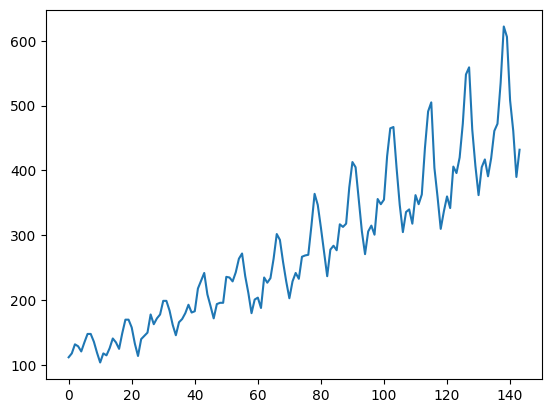

In [ ]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1) # Changed epoch from 100 to 25

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0611
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0315
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0119
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 13/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 14/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081
Epoch 15/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 16/100
94/

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score: 22.66 RMSE
Test Score: 53.86 RMSE


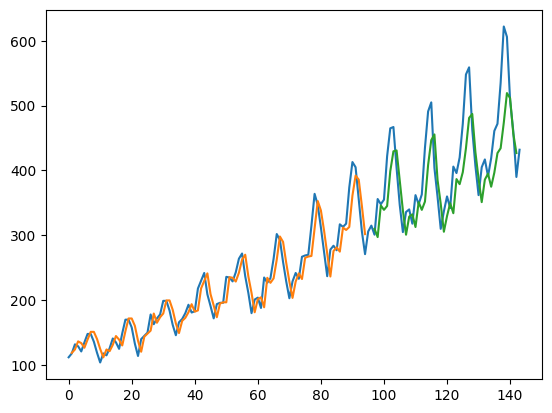

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# MODEL 2
activation='relu' not included in LSTM layer because the dataset is very small.

Changes:


*   Look_back = 10
*   Epoch = 200
*   Number of Units = 4





Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 - 2s - 18ms/step - loss: 0.0317
Epoch 2/200
85/85 - 0s - 3ms/step - loss: 0.0111
Epoch 3/200
85/85 - 0s - 4ms/step - loss: 0.0085
Epoch 4/200
85/85 - 0s - 3ms/step - loss: 0.0075
Epoch 5/200
85/85 - 0s - 4ms/step - loss: 0.0064
Epoch 6/200
85/85 - 0s - 3ms/step - loss: 0.0056
Epoch 7/200
85/85 - 0s - 4ms/step - loss: 0.0050
Epoch 8/200
85/85 - 0s - 3ms/step - loss: 0.0047
Epoch 9/200
85/85 - 0s - 4ms/step - loss: 0.0046
Epoch 10/200
85/85 - 0s - 3ms/step - loss: 0.0045
Epoch 11/200
85/85 - 0s - 4ms/step - loss: 0.0045
Epoch 12/200
85/85 - 0s - 3ms/step - loss: 0.0044
Epoch 13/200
85/85 - 0s - 3ms/step - loss: 0.0044
Epoch 14/200
85/85 - 0s - 3ms/step - loss: 0.0044
Epoch 15/200
85/85 - 0s - 4ms/step - loss: 0.0044
Epoch 16/200
85/85 - 1s - 7ms/step - loss: 0.0043
Epoch 17/200
85/85 - 0s - 4ms/step - loss: 0.0043
Epoch 18/200
85/85 - 0s - 4ms/step - loss: 0.0043
Epoch 19/200
85/85 - 1s - 7ms/step - loss: 0.0042
Epoch 20/200
85/85 - 1s - 7ms/step - loss: 0.0042
Epoch 21/200
85/85 -

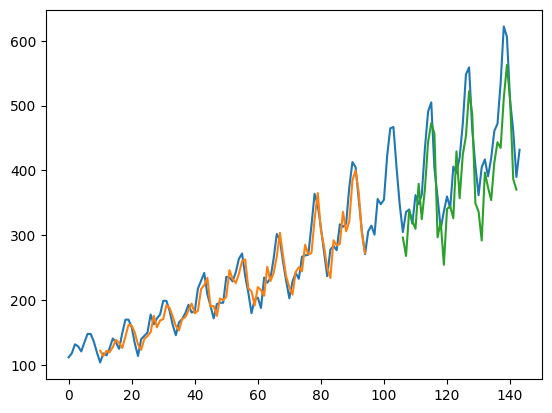

In [ ]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1

look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4,input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)




# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Using K-Fold Cross Validation (Sort-of)
This instead uses TimeSeriesSplit which is sort of like CrossValidation for LSTMs.

For example, if we have a dataset with 10 observations ([1, 2, 3, ..., 10]) and set n_splits=3, the splits will look like this:

Fold 1:
Training set: [1, 2, 3, 4]
Testing set: [5, 6]

Fold 2:
Training set: [1, 2, 3, 4, 5, 6]
Testing set: [7, 8]

Fold 3:
Training set: [1, 2, 3, 4, 5, 6, 7, 8]
Testing set: [9, 10]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score for this fold: 14.09 RMSE
Test Score for this fold: 24.75 RMSE


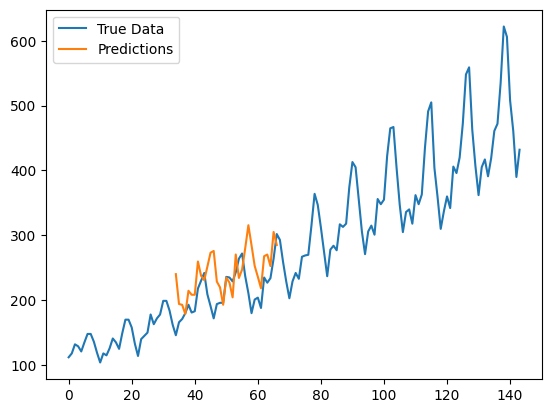

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score for this fold: 16.23 RMSE
Test Score for this fold: 67.11 RMSE


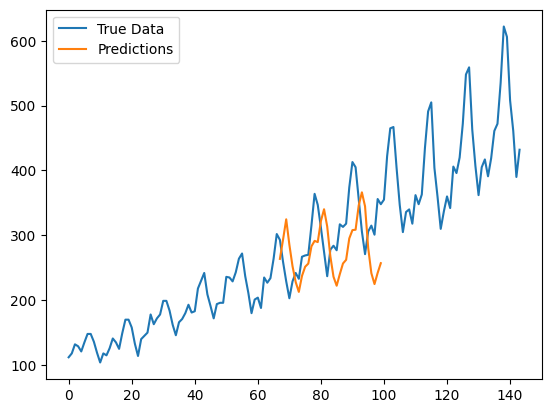

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score for this fold: 20.90 RMSE
Test Score for this fold: 46.01 RMSE


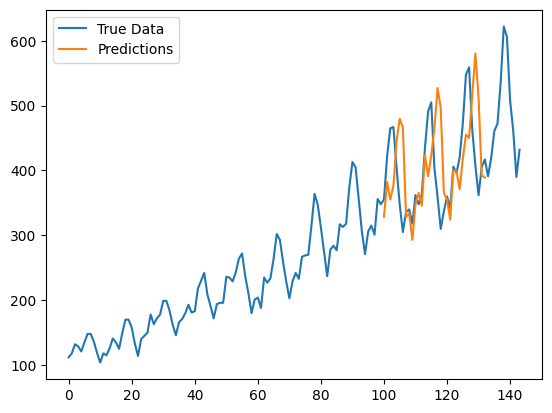

In [ ]:
# LSTM for international airline passengers problem with time step regression framing
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# reshape into X=t and Y=t+1
look_back = 10
X, y = create_dataset(dataset, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
# Create TimeSeriesSplit instance
tscv = TimeSeriesSplit(n_splits=3)  # 3 folds

# Loop through each fold
for train_index, test_index in tscv.split(X):
    # Split data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create and fit the LSTM network
    model2 = Sequential()
    model2.add(LSTM(4,input_shape=(look_back, 1)))
    model2.add(Dense(1))
    model2.compile(loss='mean_squared_error', optimizer='adam')

    # Fit the model (train for 300 epochs)
    model2.fit(X_train, y_train, epochs=350, batch_size=1, verbose=0)

    # Make predictions
    trainPredict = model2.predict(X_train)
    testPredict = model2.predict(X_test)

    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    y_train_inv = scaler.inverse_transform([y_train])
    testPredict = scaler.inverse_transform(testPredict)
    y_test_inv = scaler.inverse_transform([y_test])

    # Calculate RMSE
    trainScore = np.sqrt(mean_squared_error(y_train_inv[0], trainPredict[:, 0]))
    print(f'Train Score for this fold: {trainScore:.2f} RMSE')
    testScore = np.sqrt(mean_squared_error(y_test_inv[0], testPredict[:, 0]))
    print(f'Test Score for this fold: {testScore:.2f} RMSE')

    # Plot baseline and predictions for the current fold
    plt.plot(scaler.inverse_transform(dataset), label='True Data')
    plt.plot(np.arange(len(trainPredict), len(trainPredict) + len(testPredict)), testPredict, label='Predictions')
    plt.legend()
    plt.show()

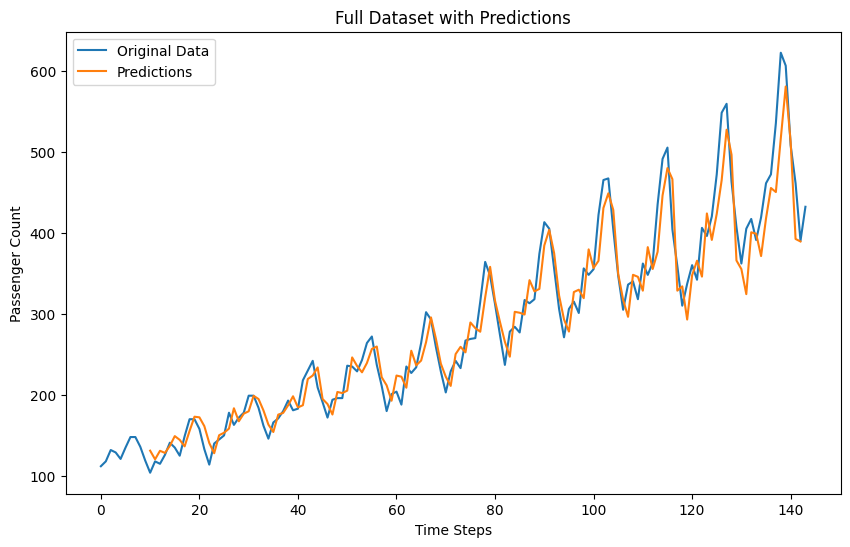

In [ ]:
# Initialize full prediction array
fullPredict = np.empty_like(dataset)
fullPredict[:, :] = np.nan

# Place the train predictions
fullPredict[look_back:look_back + len(trainPredict), :] = trainPredict

# Place the test predictions
fullPredict[len(trainPredict) + (look_back):len(trainPredict) + len(testPredict) + (look_back), :] = testPredict

# Plot everything
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset), label="Original Data")
plt.plot(fullPredict, label="Predictions")
plt.title("Full Dataset with Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Passenger Count")
plt.legend()
plt.show()



In [ ]:
print(f"Train RMSE: {trainScore:.2f}")
print(f"Test RMSE: {testScore:.2f}")


Train RMSE: 20.90
Test RMSE: 46.01
